# Segment Anything on LiDAR data


In [1]:
from segment_lidar import samlidar, view
import matplotlib.pyplot as plt
from sklearn import ensemble
from math import floor
import numpy as np
import cv2 as cv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Initialize the Segment Anything Model

- **ckpt_path:** The path to the model checkpoint.
- **model_type:** The model type to use according the checkpoint.
- **resolution:** The resolution of the LiDAR points to generate the raster.


In [22]:
viewpoint = view.TopView()
model = samlidar.SamLidar(
    ckpt_path="/mnt/Poznan_Internship/sam_vit_h_4b8939.pth",
    model_type="vit_h"
)

## Read from a Point Cloud data file (.las, .laz)


In [23]:
points = model.read("/mnt/Poznan_Internship/Data/CampusTmp/cloud2853085222bfe35e_Block_3.las")

Reading /mnt/Poznan_Internship/Data/CampusTmp/cloud2853085222bfe35e_Block_3.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 3.33 seconds. The point cloud contains 29378196 points.



In [24]:
# cloud, non_ground, ground = model.csf(points, class_threshold=0.1)

In [25]:
labels, segment_image, image = model.segment(points=points, view=viewpoint, image_path="./raster.tif", labels_path="./labeled.tif")
# model.write(points=cloud, non_ground=non_ground, ground=ground, segment_ids=labels, save_path="segmented.las")

- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 49.51 seconds. Number of instances: 1704



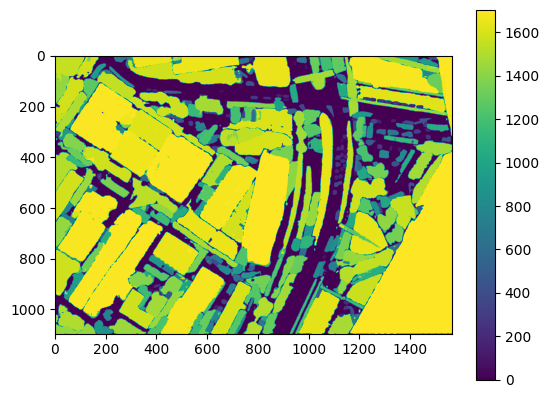

In [26]:
im = plt.imshow(segment_image)
plt.colorbar(im)

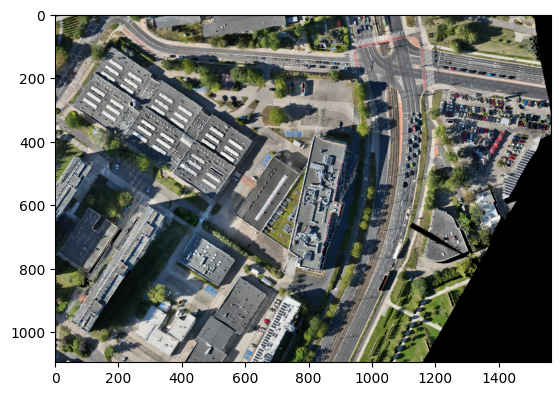

In [27]:
im = plt.imshow(image.transpose(1, 2, 0))

In [28]:
image = image.transpose((1, 2 ,0))

In [29]:
labels = np.unique(segment_image)

In [30]:
segments_img = dict()
filter_size = 1000

for l in labels:
    mask = np.zeros(image.shape, dtype=int)
    mask[segment_image == l] = [1, 1, 1]
    result = image * mask
    seg = np.argwhere(result)
    if not seg.shape[0] or not seg.shape[1]:
        continue
    if np.sum(seg.shape[:1]) < filter_size:
        continue

    minx, maxx = np.min(seg[:, 0]), np.max(seg[:, 0])
    miny, maxy = np.min(seg[:, 1]), np.max(seg[:, 1])
    segments_img.update({l: result[minx:maxx + 1, miny:maxy + 1]})

In [31]:
def resize_image(a: np.ndarray, size: tuple, preserve_aspect_ratio: bool = True, debug: bool = False):
    assert len(a.shape) == 3, "input matrix should have a shape HxWx3"
    assert a.shape[-1] == 3, "input matrix should be a 3 channels image"

    (height, width, _) = a.shape

    (output_height, output_width) = size
    assert  output_height > 0 and output_width > 0

    aspect_ratio = 1.0
    if preserve_aspect_ratio:
        aspect_ratio = float(width) / float(height)
    
    (adjusted_height, adjusted_width) = size
    if aspect_ratio > 1.0:
        adjusted_height = int(output_height * (aspect_ratio - 1))
    elif aspect_ratio < 1.0:
        adjusted_width = int(output_width * aspect_ratio)
    
    offset_x, offset_y = floor(abs(output_width - adjusted_width) / 2), floor(abs(output_height - adjusted_height) / 2)
    assert offset_x >= 0 and offset_y >= 0, "offset_x and offset_y should be equal or greater than zero"
    
    if debug:
        print(f"Input:\theight={height} width={width} (ratio: {aspect_ratio})")
        print(f"Adj:\theight={adjusted_height} width={adjusted_width}")
        print(f"Output:\theight={output_height} width={output_width}")
        print(f"Offset:\tx={offset_x} y={offset_y}")

    result = cv.resize(a.astype('float32'), (adjusted_width, adjusted_height), interpolation=cv.INTER_NEAREST).astype(int)
    result = np.pad(result, [(offset_y, offset_y), (offset_x, offset_x), (0, 0)], mode="constant")

    # Because of round values we can get errors between 1 and -1 pixels
    if result.shape[0] != output_height:
        delta = abs(result.shape[0] - output_height)
        result = np.pad(result, [(0, delta), (0, 0), (0, 0)], mode="constant")
    if result.shape[1] != output_width:
        delta = abs(result.shape[1] - output_width)
        result = np.pad(result, [(0, 0), (0, delta), (0, 0)], mode="constant")
    
    assert result.shape[:-1] == size, "output should match expected size"
    
    return result.astype(np.double)

# Use Decision Tree to classify the clusters


In [32]:
MAPPING_FILE = "./train/mapping.txt"
CLASSES_FILE = "./train/classes.txt"
IMAGES_PATH = "./train/images"
INPUT_SIZE = (64, 64)

In [33]:
classes = None
with open(CLASSES_FILE, "r") as cf:
    nb_classes = len(cf.readlines())
    classes = np.diag((nb_classes, nb_classes)) / nb_classes

In [34]:
x = []
y = []
with open(MAPPING_FILE, "r") as mf:
    annotations = mf.readlines()
    nb_images = len(annotations)
    for i in range(0, nb_images):
        [img_name, classe] = annotations[i].split(" ")
        img = cv.imread(f"{IMAGES_PATH}/{img_name}")
        x.append([
            np.mean(img[:, :, 0]),
            np.mean(img[:, :, 1]),
            np.mean(img[:, :, 2]),
            np.median(img[:, :, 0]),
            np.median(img[:, :, 1]),
            np.median(img[:, :, 2]),
        ])
        y.append(int(classe.replace("\n", "")))

In [35]:
model = ensemble.HistGradientBoostingClassifier(learning_rate=0.01)
model.fit(x, y)

HistGradientBoostingClassifier(learning_rate=0.01)

In [36]:
# plt.figure(figsize=(20, 20))
# tree.plot_tree(model, class_names=["Vegetation", "Building"])
# plt.show()

In [37]:
buildings = []
vegetations = []
for segment, img in segments_img.items():
    kind = "Building" if model.predict([
        [
            np.mean(img[:, :, 0]),
            np.mean(img[:, :, 1]),
            np.mean(img[:, :, 2]),
            np.median(img[:, :, 0]),
            np.median(img[:, :, 1]),
            np.median(img[:, :, 2]),
        ]
    ]) else "Vegetation"
    if kind == "Building":
        buildings.append(segment)
    else:
        vegetations.append(segment)
print(buildings)

[339, 351, 363, 368, 369, 377, 397, 400, 419, 423, 425, 442, 445, 446, 447, 449, 459, 480, 487, 492, 499, 554, 559, 563, 568, 569, 571, 612, 614, 617, 631, 633, 636, 640, 655, 664, 672, 677, 686, 692, 700, 720, 727, 731, 747, 749, 750, 765, 767, 777, 792, 796, 797, 802, 812, 813, 816, 817, 826, 853, 860, 865, 901, 903, 905, 906, 919, 925, 932, 934, 952, 961, 965, 969, 991, 1017, 1020, 1035, 1041, 1044, 1046, 1049, 1052, 1068, 1072, 1088, 1104, 1116, 1117, 1142, 1150, 1160, 1162, 1166, 1185, 1194, 1213, 1217, 1232, 1254, 1264, 1267, 1283, 1293, 1296, 1303, 1305, 1306, 1332, 1351, 1356, 1397, 1400, 1440, 1450, 1466, 1467, 1470, 1482, 1483, 1485, 1502, 1505, 1532, 1543, 1553, 1559, 1578, 1579, 1586, 1603, 1604, 1617, 1624, 1630, 1641, 1650, 1654, 1655, 1663, 1668, 1682, 1684, 1686, 1691, 1696, 1697, 1702]


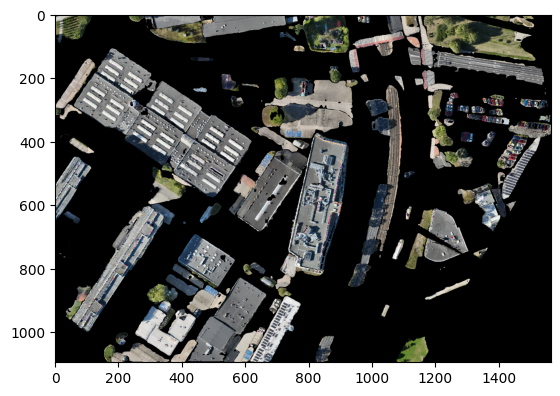

In [38]:
mask = np.zeros(image.shape, dtype=int)
for b in buildings:
    mask[segment_image == b] = [1, 1, 1]
plt.imshow(image * mask)

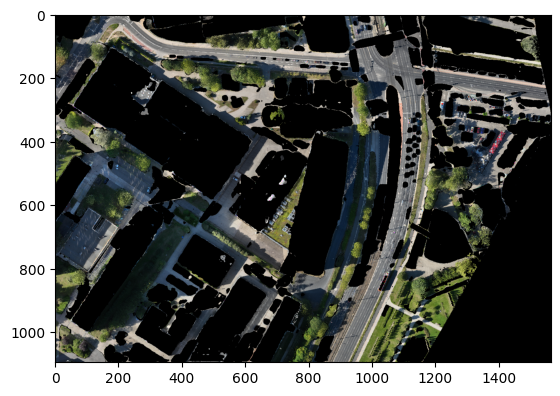

In [39]:
mask = np.zeros(image.shape, dtype=int)
for b in vegetations:
    mask[segment_image == b] = [1, 1, 1]
plt.imshow(image * mask)

## Road isolation and filling


In [42]:
import skimage.filters as filters
import skimage.morphology as morph

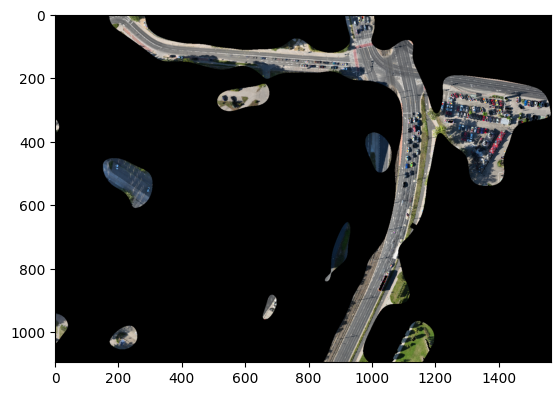

In [49]:
mask = np.zeros(segment_image.shape, dtype=int)
# for b in vegetations:
#     mask[segment_image == b] = [1, 1, 1]
mask[segment_image == 0] = 1
#mask = filters.butterworth(mask)

mask = morph.area_closing(mask, 10000)
mask = filters.gaussian(mask, sigma=30, preserve_range=True)

# mask = filters.meijering(mask, sigmas=range(1, 5, 2))
threshold = 0.5
mask[mask > threshold] = 1
mask[mask <= threshold] = 0

mask = np.expand_dims(mask, axis=2).astype(int)
plt.imshow(image * mask)